# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from importlib import reload
import utils, models
reload(utils)
reload(models)
from utils import model_inputs, get_flow_dataset, split_benign_attack, get_same_len_benign_attack
from models import generator, discriminator

In [3]:
dataset = get_flow_dataset()
benign, attack = split_benign_attack(dataset)
benign, attack = get_same_len_benign_attack(benign, attack)

In [4]:
benign.shape

(9924, 40)

In [5]:
attack.shape

(9924, 40)

## Hyperparameters

In [6]:
# Size of input image to discriminator
input_size = 40
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_benign, input_z, input_attack_remains` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, z_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for benign flow data and one for attack flow data. Since we want the weights to be the same for both benign and attack flow data, we need to reuse the variables. For the attack flow data, we're getting it from the output of the generator concatenated with remaining part of attack feature called `g_model`. So the benign data discriminator is `discriminator(input_benign)` while the attack discriminator is `discriminator(g_model, reuse=True)`.

In [7]:
tf.reset_default_graph()

# Create our input placeholders
input_benign, input_z, input_attack_remains = model_inputs(input_size, z_size, attack_remains_dim=input_size - z_size)

# Build the model
z_generated = generator(input_z, z_size, n_units=g_hidden_size, alpha=alpha)
g_model = tf.concat([z_generated, input_attack_remains], 1)
# g_model is the generator output concatenated with the remaining part of attack features

d_model_benign, d_logits_benign = discriminator(input_benign, n_units=d_hidden_size, alpha=alpha)
d_model_attack, d_logits_attack = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for benign and attack flows, `d_loss = d_loss_benign + d_loss_attack`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the flows in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the benign flow logits, we'll use `d_logits_benign` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(tensor) * (1 - smooth)`

The discriminator loss for the attack flow data is similar. The logits are `d_logits_attack`, which we got from passing the generator output concatenated with remaing part of attack flow features to the discriminator. These attack logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for benign flows and 0 for attack images, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_attack`, the attack flow logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

In [8]:
# Calculate losses
d_loss_benign = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_benign, 
                                                          labels=tf.ones_like(d_logits_benign) * (1 - smooth)))
d_loss_attack = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack, 
                                                          labels=tf.zeros_like(d_logits_attack)))
d_loss = d_loss_benign + d_loss_attack

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack,
                                                     labels=tf.ones_like(d_logits_attack)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [9]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [10]:
from copy import deepcopy

batch_size = 100
epochs = 10
losses = []
original_flows, generated_flows, attack_scores = [], [], []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        np.random.shuffle(benign)
        np.random.shuffle(attack)
        original_flows.append([])
        generated_flows.append([])
        attack_scores.append([])
        for ii in range(benign.shape[0]//batch_size):
            batch_benign = benign[ii * batch_size:(ii + 1) * batch_size]
            
            batch_attack = attack[ii * batch_size:(ii + 1) * batch_size]
            batch_z = batch_attack[:,:z_size]
            batch_attack_remains = batch_attack[:,z_size:]
            
            if ii % 5 == 0:
                original_flow = batch_attack
                generated_flow = sess.run(g_model, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                attack_score = sess.run(d_model_attack, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                original_flows[-1].append(deepcopy(original_flow[0]))
                generated_flows[-1].append(generated_flow[0])
                attack_scores[-1].append(attack_score[0][0])
                
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_benign: batch_benign, input_z: batch_z, input_attack_remains: batch_attack_remains})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_benign: batch_benign, input_attack_remains: batch_attack_remains})
        train_loss_g = g_loss.eval({input_z: batch_z, input_attack_remains: batch_attack_remains})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1/10... Discriminator Loss: 0.9629... Generator Loss: 1.2244
Epoch 2/10... Discriminator Loss: 1.4939... Generator Loss: 0.6016
Epoch 3/10... Discriminator Loss: 1.4048... Generator Loss: 0.7446
Epoch 4/10... Discriminator Loss: 1.8986... Generator Loss: 0.9732
Epoch 5/10... Discriminator Loss: 0.4804... Generator Loss: 3.2734
Epoch 6/10... Discriminator Loss: 0.5727... Generator Loss: 2.6924
Epoch 7/10... Discriminator Loss: 0.4300... Generator Loss: 3.2106
Epoch 8/10... Discriminator Loss: 0.6423... Generator Loss: 2.0066
Epoch 9/10... Discriminator Loss: 0.4177... Generator Loss: 3.6846
Epoch 10/10... Discriminator Loss: 1.0807... Generator Loss: 1.0811


## Training loss

Here we'll check out the training losses for the generator and discriminator.

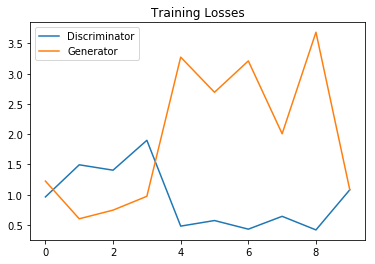

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [12]:
import math

def split_to_two_nearest_factor(x):
    sqrt_x = int(math.sqrt(x))
    i = sqrt_x
    while x % i != 0:
        i -= 1
    return (i, x // i)

In [13]:
fig_size = split_to_two_nearest_factor(input_size)

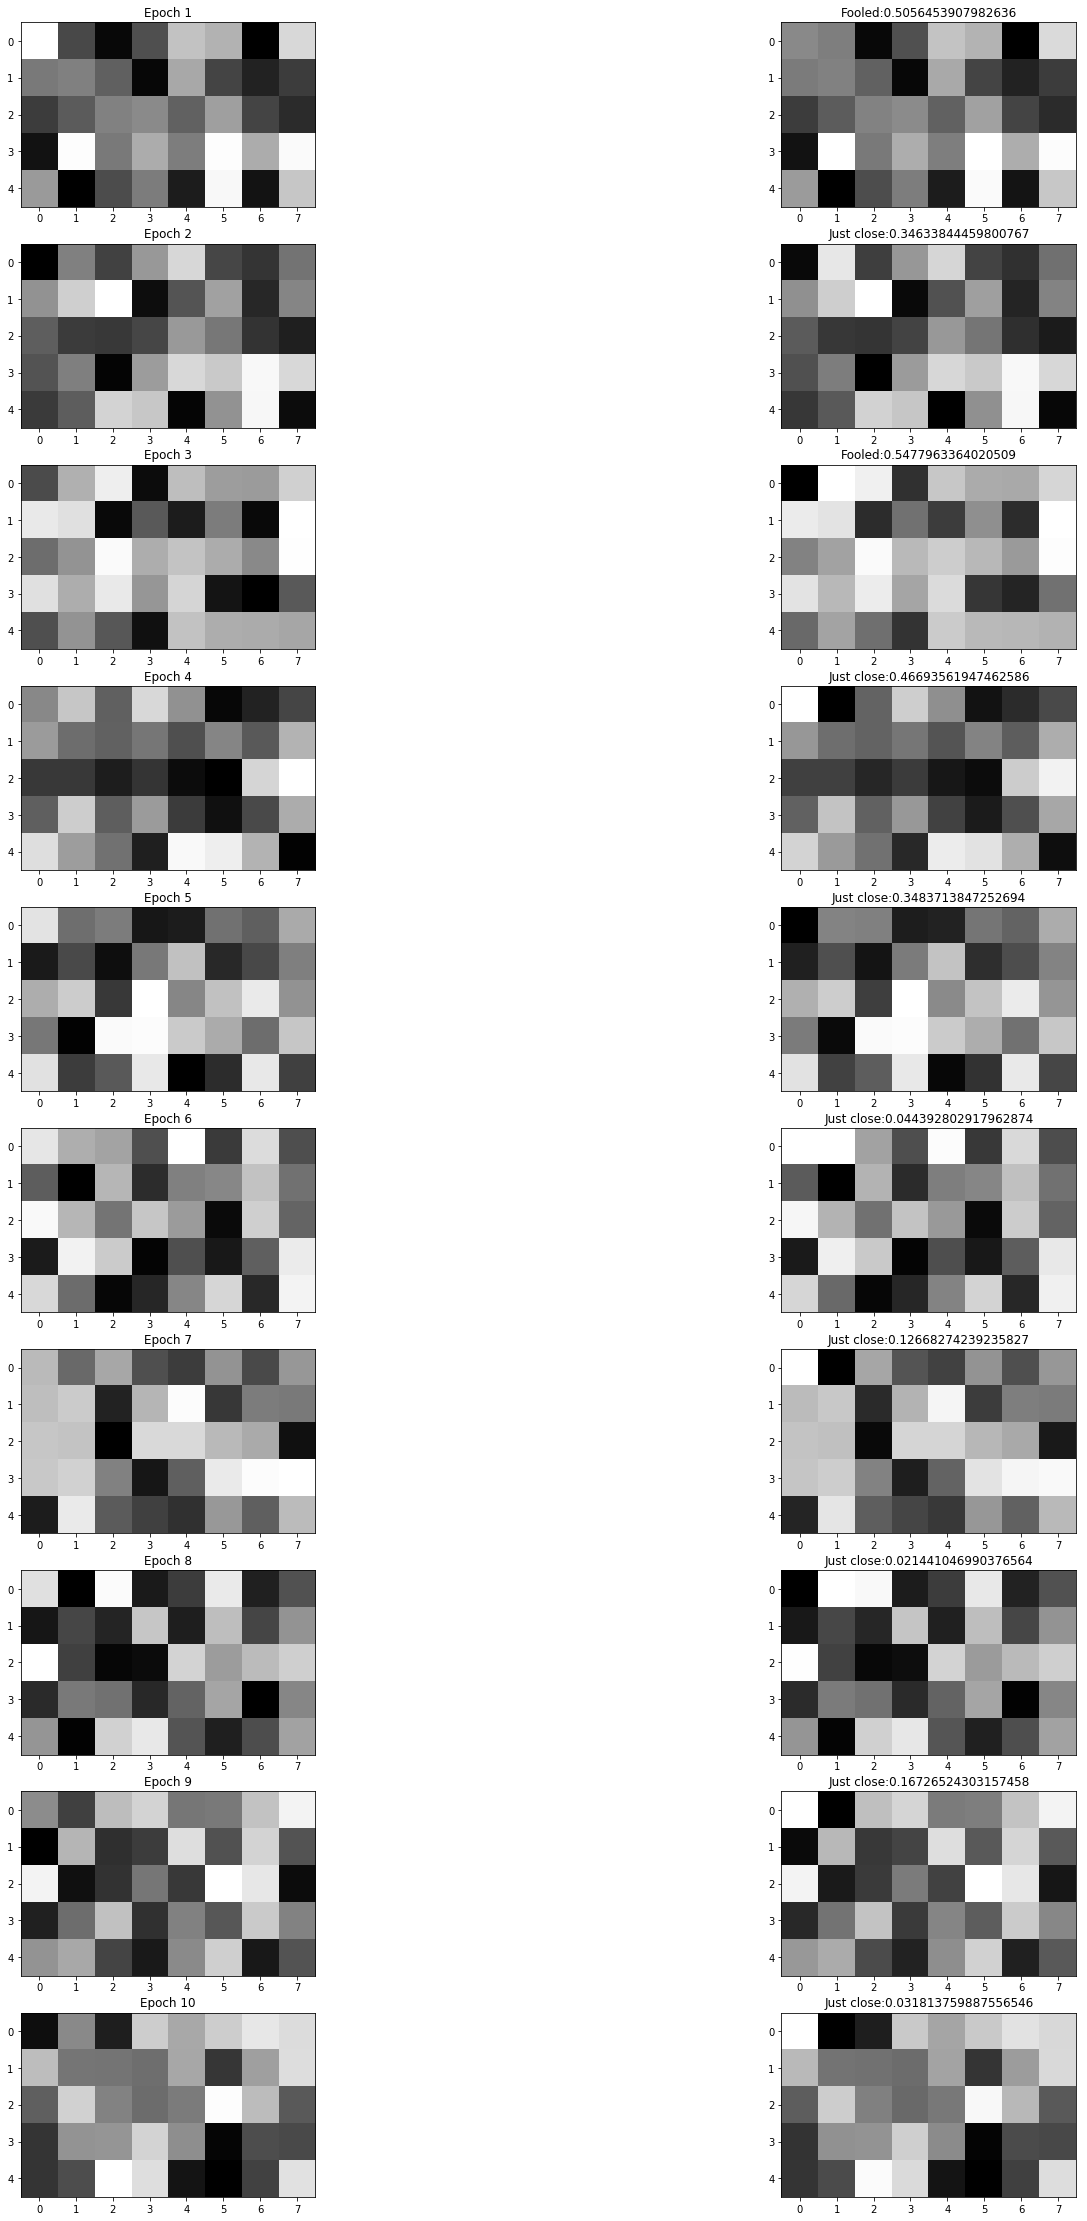

In [24]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(fig_size[0] * 5, fig_size[1] * 5))
columns = 2
rows = len(original_flows)
for i in range(rows):
    original_img = original_flows[i][0]
    generated_img = generated_flows[i][0]
    ax_original = fig.add_subplot(rows, columns, i * 2 + 1)
    ax_original.set_title('Epoch {epoch}'.format(epoch=i + 1))
    plt.imshow(original_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
    ax_generated = fig.add_subplot(rows, columns, i * 2 + 2)
    plt.imshow(generated_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
    if attack_scores[i][0] >= 0.5:
        ax_generated.set_title('Fooled:' + str(attack_scores[i][0]))
    else:
        ax_generated.set_title('Just close:' + str(attack_scores[i][0]))
plt.show()